In [23]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
#sys.path.append('/n/des/lee.5922/programs/cosmolike/MG_musigma/')
from noshellavg_v2 import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Call class. shot noise = 0, FoG = 0

In [146]:
# b = galaxy bias
# f = structure growth rate
# s = velocity dispersion in FoG term 
# nn = shot noise 
cosmo = class_covariance(KMIN=0.0001, KMAX = 50, n=20000, RMIN = 0.001, RMAX = 200, n2 = 501, 
                         b = 2.0, f = 0.74, s=0.0, nn=0, rscale = 'lin', kscale='log')

# calling matter power spectrum from camb
cosmo.MatterPower()

# P model and Xi model comparison with theory 

Compare theoretical P(k) and my module

Theory:
$P_0 = (b^2 + 2/3 bf + 1/5 f^2) P_{matter}(k)$

In [148]:
Pmatter = cosmo.Pm_interp(cosmo.kcenter_y) #from camb

P0_theory = (cosmo.b**2 + 2./3*cosmo.b*cosmo.f + 1./5 *cosmo.f**2)*Pmatter
P0_mine = cosmo.multipole_P(0)

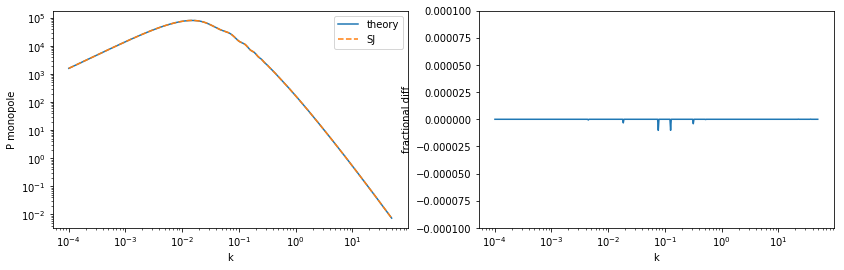

In [192]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (14,4))
ax.loglog(cosmo.kcenter_y, P0_theory, label='theory')
ax.loglog(cosmo.kcenter_y, P0_mine, '--', label = 'SJ')
ax.set_xlabel('k')
ax.set_ylabel('P monopole')
ax.legend()

ax2.semilogx(cosmo.kcenter_y, 1.-P0_theory/P0_mine)
ax2.set_ylim(-1e-04, 1e-04)
ax2.set_xlabel('k')
ax2.set_ylabel('fractional diff')

Compare theoretical \xi(r) and my module

Thoery :

$\xi_0 = (b^2 + 2/3 bf + 1/5 f^2) \xi_{matter}(r)$

In [150]:
Pmatter = cosmo.Pm_interp(cosmo.kbin) #from camb

# Fourier transform of matter Power spectrum
xi_matter = cosmo.fourier_transform_kr(0, cosmo.kbin, Pmatter) 
xi0_theory = (cosmo.b**2 + 2./3*cosmo.b*cosmo.f + 1./5 *cosmo.f**2)*xi_matter
xi0_mine = cosmo.multipole_Xi(0)

(-1e-12, 1e-12)

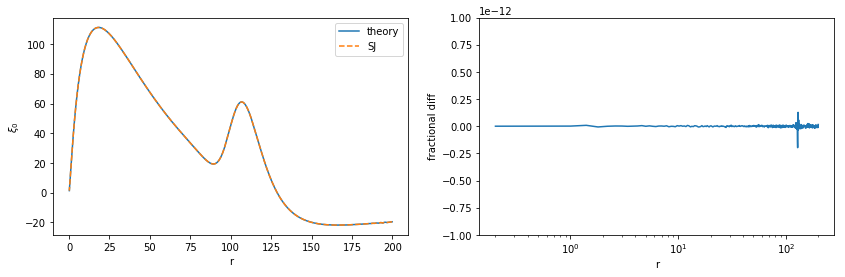

In [193]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (14,4))
ax.plot(cosmo.rcenter, cosmo.rcenter**2*xi0_theory, label = 'theory')
ax.plot(cosmo.rcenter, cosmo.rcenter**2*xi0_mine, '--', label='SJ')
ax.set_xlabel('r')
ax.set_ylabel(r'$\xi_0$')
ax.legend()

ax2.semilogx(cosmo.rcenter, 1.-xi0_theory/xi0_mine)
ax2.set_xlabel('r')
ax2.set_ylabel('fractional diff')
ax2.set_ylim(-1e-12, 1e-12)

# dp/db and dxi/db comparison with theory

Theory : 

$\frac{dp_0}{db} = \left(2b + \frac{2}{3} f \right) P_{m}(k)$

$\frac{d\xi_0}{db} = \left(2b + \frac{2}{3} f \right) \xi_{m}(k)$

In [152]:
Pmatter = cosmo.Pm_interp(cosmo.kcenter_y) #matter power spectrum from camb

In [162]:
# theory
dpdb_theory = (2*cosmo.b + 2./3*cosmo.f) * Pmatter
dxidb_theory = (2*cosmo.b + 2./3*cosmo.f) * xi_matter

# derivative dp/db, dxi/db
dpdb_mine, _, _ = cosmo.derivative_P_bfs(0)
dxidb_mine, _, _ = cosmo.derivative_bfs(0)   # Fourier transform of dp/db

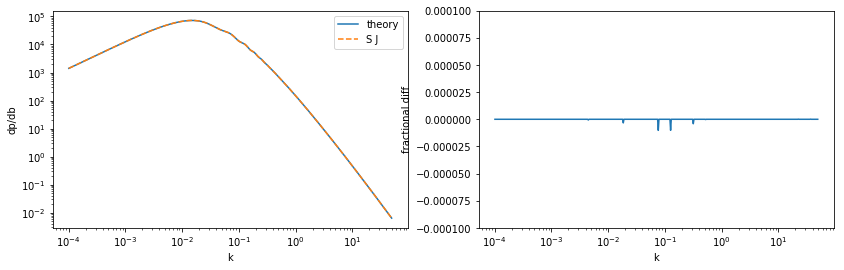

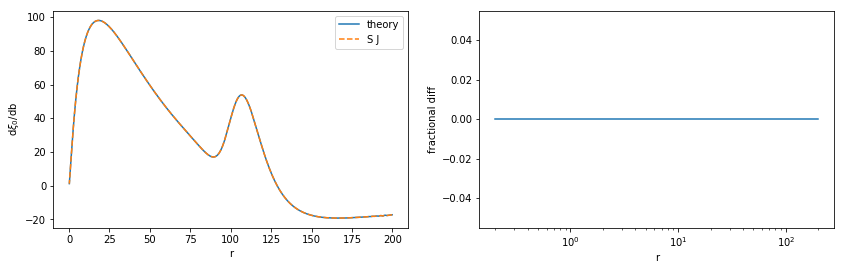

In [194]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (14,4))
ax.loglog(cosmo.kcenter_y, dpdb_theory, label='theory')
ax.loglog(cosmo.kcenter_y, dpdb_mine, '--', label = 'S J')
ax.set_xlabel('k')
ax.set_ylabel('dp/db')
ax.legend()

ax2.semilogx(cosmo.kcenter_y, 1.-dpdb_theory/dpdb_mine)
ax2.set_ylim(-1e-04, 1e-04)
ax2.set_xlabel('k')
ax2.set_ylabel('fractional diff')

fig, (ax, ax2) = plt.subplots(1,2, figsize = (14,4))
ax.plot(cosmo.rcenter, cosmo.rcenter**2*dxidb_theory, label = 'theory')
ax.plot(cosmo.rcenter, cosmo.rcenter**2*dxidb_mine, '--', label='S J')
ax.set_xlabel('r')
ax.set_ylabel(r'd$\xi_0$/db')
ax.legend()

ax2.semilogx(cosmo.rcenter, 1.-dxidb_theory/dxidb_theory)
ax2.set_xlabel('r')
ax2.set_ylabel('fractional diff')
#ax2.set_ylim(-1e-13, 1e-13)

### Covariance Matrices 

In [164]:
# calculate covariance matrix
covp_model = cosmo.covariance_PP(0,0)        # cov P monopole
covxi_model = cosmo.FT_covariance_Xi(0,0)    # cov Xi monopole  : double bessel FT of covp_model
covpxi_model = cosmo.FT_covariance_PXi(0,0)  # cov Pxi monopole : FT of covp_model

### In order to simply the problem, choose only 1 kbin and only 1 rbin

In [165]:
#dpdb, dxidb
dpdb_model, _, _ = cosmo.derivative_P_bfs(0)
dxidb_model, _,_ = cosmo.derivative_bfs(0)

In [166]:
def check_estimator( F=None, kind = 0, kN=1, rind=0, rN=1):
    """
    F : output file. if None, results will be printed out 
    kind : kbin index
    rind : rbin index
    kN : number of k bin that will be included in covariance calculation. if 1, use only one kbin.
    rN : number of r bin that will be included in covariance calculation. if 1, use only one rbin.    
    """
    
    from numpy.linalg import inv
    
    krange =  'k = {:10} ~ {:10}'.format(cosmo.kcenter_y[kind], cosmo.kcenter_y[kind+kN])
    rrange = 'r = {:10} ~ {:10}'.format(cosmo.rcenter[rind+rN], cosmo.rcenter[rind])

    if F is None : 
        print krange
        print rrange

    # dp/db and dxi/db at a given k and r scale.
    dpdb = dpdb_model[kind:kind+kN]
    dxidb = dxidb_model[rind:rind+rN]
    dcdb = np.hstack((dpdb, dxidb))

    # covariance matrix at a given k and r scale
    cov_p = covp_model[kind:kind+kN, kind:kind+kN]
    cov_xi = covxi_model[rind:rind+rN, rind:rind+rN]
    cov_pxi = covpxi_model[kind:kind+kN, rind:rind+rN]
    cov_tot = np.vstack(( np.hstack((cov_p, cov_pxi)), np.hstack((cov_pxi.T, cov_xi)) ))

    # Bias Fisher matrix 
    F_pb = np.dot( np.dot( dpdb, inv(cov_p) ), dpdb.T )
    F_xb = np.dot( np.dot( dxidb, inv(cov_xi) ), dxidb.T )
    F_cb = np.dot( np.dot( dcdb, inv(cov_tot) ), dcdb.T )
    F_db = F_pb + F_xb

    # Check if the inverse of covariance matrix has invalid value in diagonals.
    if np.sum( inv(cov_tot).diagonal() < 0) > 0 : print 'Warning : negative Fisher diagonals'
        
    # Getting sigma_b 
    sigma_pb = np.sqrt(1./F_pb)  # P only
    sigma_xb = np.sqrt(1./F_xb)  # Xi only
    sigma_cb = np.sqrt(1./F_cb)  # combined
    sigma_db = np.sqrt(1./F_db)  # diff sky
    
    # Check if the results are valid or not.
    # if combined error is smaller than diff sky error, return 1, otherwise return 0.
    if sigma_cb < sigma_db : 
        if F is None : print "Failed : different sky estimator > Combined estimator!!!"
        mask = 1
    else : 
        if F is None : print 'Success'
        mask = 0
    
    if F is None : 
        print '--------------------------------------'
        print 'sigma_p    = ',sigma_pb
        print 'sigma_xi   = ',sigma_xb
        print 'sigma_com  = ',sigma_cb
        print 'sigma_diff = ',sigma_db
        print ''
    else :
        F.write('{} {} {}\n'.format(cosmo.rcenter[rind+rN], cosmo.rcenter[rind], mask))
        F.flush()  

### Test for arbitrary 1 kbin and 1 rbin

Test with the smallest r bin and the smallest k bin : succeed

In [185]:
check_estimator(F=None, kind=1, kN=1, rind=498, rN=1)

k = 0.000104023430609 ~ 0.000106795254229
r =   0.200999 ~   0.600997
Success
--------------------------------------
sigma_p    =  597.3735232240501
sigma_xi   =  0.0002040685229432231
sigma_com  =  0.00020406852294322308
sigma_diff =  0.0002040685229432112



Test with the smallest k bin and the largest r bin : Test Failed. 

In [186]:
check_estimator(F=None, kind=1, kN=1, rind=1, rN=1)

k = 0.000104023430609 ~ 0.000106795254229
r = 199.000005 ~ 199.400003
Failed : different sky estimator > Combined estimator!!!
--------------------------------------
sigma_p    =  597.3735232240501
sigma_xi   =  0.5690517552106733
sigma_com  =  0.5690514941905191
sigma_diff =  0.5690514970244465



### Test for all bins to see where the estimator fails.

##### Do calculation for $i_{th}$ kbin and $j_{th}$ rbin. 

In [179]:
kN = 1
rN = 1

In [180]:
import os

dir = '../data_txt/consistency_check_rN{}_kN{}/'.format(rN, kN)
if not os.path.exists(dir) : os.makedirs(dir)

for ki in range(cosmo.kcenter_y.size-kN):  
    F = open(dir+'/consistency_check_k{}.txt'.format(ki), "w")
    #F.write('#' + krange )
    F.write('# r1, r2, mask (1==failed, 2==success)\n')
    for ri in range(cosmo.rcenter.size-rN):
        check_estimator(F=F, kind=ki, kN=kN, rind=ri, rN=rN)     
    print '{}/{} \r'.format(ki+1, cosmo.kcenter_y.size-1),
    F.close()


effectiver = np.zeros(( cosmo.kcenter_y.size-kN, 2 ))
for ki in range(cosmo.kcenter_y.size-kN):
    kcenter, _, mask = np.genfromtxt(dir+'/consistency_check_k{}.txt'.format(ki), unpack=True)
    mask = np.array(mask, dtype=bool)
    effective_r = cosmo.rcenter[:-rN][~mask]
    #print effective_r.min(), effective_r.max()
    effectiver[ki,0] = effective_r.max()
    effectiver[ki,1] = effective_r.min()
    #F2.write('{} {} {}\n'.format(cosmo.kcenter_y[ki],effective_r.min(),effective_r.max() ) )
    #F2.flush()

DAT_effectiver = np.column_stack((cosmo.kcenter_y[:-kN], effectiver[:,0], effectiver[:,1]))
np.savetxt(dir+'consistency_check_rlim.txt', DAT_effectiver, header='# kcenter, rmin, rmax')

##### rN = 1,  kN = 1

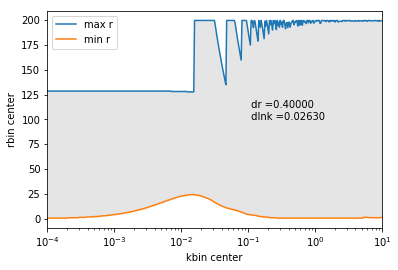

In [175]:

dir = '../data_txt/consistency_check_rN1_kN1/'
filename = dir+'/consistency_check_rlim.txt'
kcenter, effec_rmax, effec_rmin = np.loadtxt(filename, unpack=True)
fig, ax =plt.subplots()
ax.plot(kcenter, effec_rmax, label='max r')
ax.plot(kcenter, effec_rmin, label='min r')

ax.fill_between(kcenter, effec_rmax, effec_rmin, where=effec_rmax >= effec_rmin, 
                facecolor='grey', alpha = 0.2,interpolate=True)

ax.set_ylabel('rbin center')
ax.set_xlabel('kbin center')
ax.text(0.1, 100, ' dr ={:0.5f}\n dlnk ={:0.5f}'.format(cosmo.dr, cosmo.dlnk_y) )
ax.legend(loc='best')
ax.set_xlim(1e-04, 10)
ax.set_xscale('log')

fig.savefig(dir+'fig.png')

#### For a given k, estimator only succeeds when r bin is in the shade region.

#####  rN = 5,   kN = 1

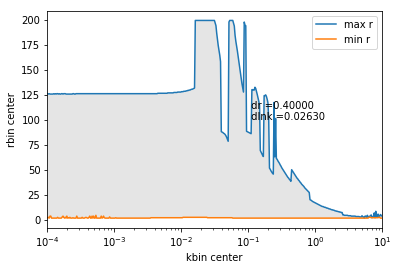

In [187]:
dir = '../data_txt/consistency_check_rN5_kN1/'
filename = dir+'/consistency_check_rlim.txt'
kcenter, effec_rmax, effec_rmin = np.loadtxt(filename, unpack=True)
fig, ax =plt.subplots()
ax.plot(kcenter, effec_rmax, label='max r')
ax.plot(kcenter, effec_rmin, label='min r')

ax.fill_between(kcenter, effec_rmax, effec_rmin, where=effec_rmax >= effec_rmin, 
                facecolor='grey', alpha = 0.2, interpolate=True)

ax.set_ylabel('rbin center')
ax.set_xlabel('kbin center')
ax.text(0.1, 100, ' dr ={:0.5f}\n dlnk ={:0.5f}'.format(cosmo.dr * rN, cosmo.dlnk_y) )
ax.legend(loc='best')
ax.set_xlim(1e-04, 10)
ax.set_xscale('log')

fig.savefig(dir+'fig.png')

##### rN = 1,  kN = 100

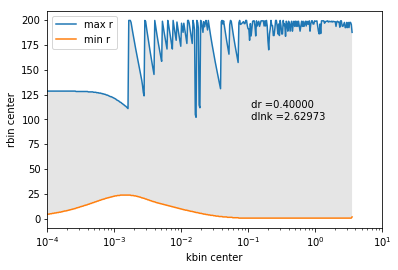

In [190]:
dir = '../data_txt/consistency_check_rN1_kN100/'
filename = dir+'/consistency_check_rlim.txt'
kcenter, effec_rmax, effec_rmin = np.loadtxt(filename, unpack=True)
fig, ax =plt.subplots()
ax.plot(kcenter, effec_rmax, label='max r')
ax.plot(kcenter, effec_rmin, label='min r')
ax.fill_between(kcenter, effec_rmax, effec_rmin, where=effec_rmax >= effec_rmin, 
                facecolor='grey', alpha = 0.2, interpolate=True)

ax.set_ylabel('rbin center')
ax.set_xlabel('kbin center')
ax.text(0.1, 100, ' dr ={:0.5f}\n dlnk ={:0.5f}'.format(cosmo.dr*rN, cosmo.dlnk_y*100) )
ax.legend(loc='best')
ax.set_xlim(1e-04, 10)
ax.set_xscale('log')

fig.savefig(dir+'fig.png')